# Creating an advanced interactive map with Bokeh



In [1]:
from bokeh.io import show, push_notebook, output_notebook
from bokeh.palettes import YlOrRd as palette  #Spectral6 as palette
from bokeh.palettes import brewer
from bokeh.plotting import figure, output_file
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LogColorMapper
)
import gdal 
import geopandas as gpd
import pysal as ps
import numpy as np

# Plot the data using Jupyter Notebook - Initialize
output_notebook()

# Read the data with Geopandas
fp = r"D:\KOODIT\Opetus\Automating-GIS-processes\AutoGIS-Sphinx\data\TravelTimes_to_5975375_RailwayStation.shp"
fp = r"C:\HY-Data\HENTENKA\KOODIT\Opetus\Automating-GIS-processes\AutoGIS-Sphinx\data\TravelTimes_to_5975375_RailwayStation.shp"
data = gpd.read_file(fp)

# Get crs
CRS = data.crs

# Read Roads 
roads_fp = r"D:\KOODIT\Opetus\Automating-GIS-processes\AutoGIS-Sphinx\data\Helsinki_map_layers\pääväylät.shp"
roads_fp = r"C:\HY-Data\HENTENKA\KOODIT\Opetus\Automating-GIS-processes\AutoGIS-Sphinx\data\Helsinki_map_layers\pääväylät.shp"
roads = gpd.read_file(roads_fp)

# Ensure that geometries are in same CRS
roads['geometry'] = roads['geometry'].to_crs(crs=CRS)

# Read Water areas
water_fp = r"D:\KOODIT\Opetus\Automating-GIS-processes\AutoGIS-Sphinx\data\Helsinki_map_layers\rantaviiva_polygon.shp"
water_fp = r"C:\HY-Data\HENTENKA\KOODIT\Opetus\Automating-GIS-processes\AutoGIS-Sphinx\data\Helsinki_map_layers\Water_areas_largest_ones_YKR_rajaus.shp" #Water_areas.shp"

water = gpd.read_file(water_fp)

# Ensure that the CRS is the same than in the grid
water['geometry'] = water['geometry'].to_crs(crs=CRS)

# Add metro line
metro_fp = r"C:\HY-Data\HENTENKA\KOODIT\Opetus\Automating-GIS-processes\AutoGIS-Sphinx\data\Helsinki_map_layers\metro.shp" 
metro = gpd.read_file(metro_fp)

# Ensure that the CRS is the same than in the grid
metro['geometry'] = metro['geometry'].to_crs(crs=CRS)

# Add rail roads
rail_fp = r"C:\HY-Data\HENTENKA\KOODIT\Opetus\Automating-GIS-processes\AutoGIS-Sphinx\data\Helsinki_map_layers\rautatie.shp" 
rail = gpd.read_file(rail_fp)

# Ensure that the CRS is the same than in the grid
rail['geometry'] = rail['geometry'].to_crs(crs=CRS)


Loading BokehJS ...

In [2]:
water.head()

AINLAHDE  ALUEJAKOON  KARTOGLK KOHDELUOKK   KOHDEOSO  KORARV  KORKEUS  \
0         1           0         0  Järvivesi  406322443     0.0      0.0   
1         1           0         0  Järvivesi  406302249     0.0      0.0   
2         1           0         0  Järvivesi  397671330     0.0      0.0   
3         1           0         0  Järvivesi  397826575     0.0      0.0   
4         1           0         0  Järvivesi  397764362     0.0      0.0   

   KORTAR  KULKUTAPA KUOLHETKI  \
0       0          0      None   
1       0          0      None   
2       0          0      None   
3       0          0      None   
4       0          0      None   

                         ...                          RYHMä_NRO  SIIRT_DX  \
0                        ...                                 64         0   
1                        ...                                 64         0   
2                        ...                                 64         0   
3                        ...                                 64         0   
4                        ...                                 64         0   

  SIIRT_DY SUUNTA  SYNTYHETKI  TASTAR  TEKSTI VERSUH          area  \
0        0      0    20080107   20000    None      0  2.998872e+06   
1        0      0    20081117   20000    None      0  1.951256e+06   
2        0      0    20101230   20000    None      0  4.100718e+06   
3        0      0    20101230   20000    None      0  2.457038e+06   
4        0      0    20071116   20000    None      0  4.942598e+06   

                                            geometry  
0  POLYGON Z ((353619.6978109663 6675027.11282258...  
1  POLYGON Z ((357365.7465094092 6676198.37116210...  
2  POLYGON Z ((370892.1807967017 6683717.44378731...  
3  POLYGON Z ((365699.5569192014 6684979.10557370...  
4  POLYGON Z ((355062.6674693294 6693435.38887666...  

[5 rows x 23 columns]

In [3]:
def getCoords(geom, coord_type):
    """Calculates coordinates ('x' or 'y') of a geometry. Can handle also MultiGeometries."""
    if geom.geom_type.startswith("Multi"):
        for i, part in enumerate(geom):
            if coord_type == 'x':
                if i == 0:
                    coord_arrays = part.coords.xy[0]
                else:
                    coord_arrays = np.concatenate([coord_arrays, part.coords.xy[0]])
            elif coord_type == 'y':
                if i == 0:
                    coord_arrays = part.coords.xy[1]
                else:
                    coord_arrays = np.concatenate([coord_arrays, part.coords.xy[1]])
        return coord_arrays
    else:
        if coord_type == 'x':
            return geom.coords.xy[0]
        elif coord_type == 'y':
            return geom.coords.xy[1]
    
def getLineCoords(row, geom_col, x_col, y_col):
    row[x_col] = list(getCoords(row[geom_col], coord_type='x'))
    row[y_col] = list(getCoords(row[geom_col], coord_type='y'))
    return row

def getPolyCoords(geometry, coord_type):
    """Calculates coordinates ('x' or 'y') of a Polygon and updates the values into 'x_col' and 'y_col' that user defines."""
    if geometry.geom_type.startswith("Multi"):
        for i, part in enumerate(geometry):
            ext = part.exterior
            if coord_type == 'x':
                if i == 0:
                    coord_arrays = np.append(ext.coords.xy[0], np.nan)
                    #coord_arrays = ext.coords.xy[0]
                    #coord_arrays = [list(ext.coords.xy[0])]
                else:
                    coord_arrays = np.concatenate([coord_arrays, np.append(ext.coords.xy[0], np.nan)])
                    #coord_arrays = np.concatenate([coord_arrays, ext.coords.xy[0]])
                    #coord_arrays.append(list(ext.coords.xy[0]))
            elif coord_type == 'y':
                if i == 0:
                    coord_arrays = np.append(ext.coords.xy[1], np.nan)
                    #coord_arrays = ext.coords.xy[1]
                    #coord_arrays = [list(ext.coords.xy[1])]
                else:
                    coord_arrays = np.concatenate([coord_arrays, np.append(ext.coords.xy[1], np.nan)])
                    #coord_arrays = np.concatenate([coord_arrays, ext.coords.xy[1]])
                    #coord_arrays.append(list(ext.coords.xy[1]))
    return coord_arrays
        
def getPolyCoordsWithMinMax(row, geom_col, x_col, y_col, x_min_col, y_min_col, x_max_col, y_max_col):
    """Calculates coordinates ('x' or 'y') of a Polygon and updates the values into 'x_col' and 'y_col' that user defines."""
    # Parse the exterior of the coordinate
    if row[geom_col].geom_type.startswith("Multi"):
        x = getPolyCoords(row[geom_col], coord_type='x')
        y = getPolyCoords(row[geom_col], coord_type='y')
        row[x_col] = x
        row[y_col] = y
    else:
        exterior = row[geom_col].exterior
        # Get the coordinates of the exterior
        x = getCoords(exterior, coord_type='x')
        y = getCoords(exterior, coord_type='y')
        # Update the row with a list of Polygon coordinate list (remember Polygon can have holes, thus coords are within nested list) 
        row[x_col] = list(x)
        row[y_col] = list(y)
    # Get min and max of the values
    x_min, x_max = min(x), max(x)
    y_min, y_max = min(y), max(y)
    
    row[x_min_col] = x_min
    row[x_max_col] = x_max
    row[y_min_col] = y_min
    row[y_max_col] = y_max
    # Return the result
    return row

# Bokeh documentation regarding the MultiPolygon issues can be found here (it is an open issue)
# https://github.com/bokeh/bokeh/issues/2321
    
# Calculate the x and y coordinates plus their minimum and maximum values
data = data.apply(getPolyCoordsWithMinMax, geom_col='geometry', x_col='x', y_col='y', 
                  x_min_col='x_min', y_min_col='y_min', x_max_col='x_max', y_max_col='y_max',
                  axis=1)

# Calculate the x and y values of road geometries
roads = roads.apply(getLineCoords, geom_col='geometry', x_col='x', y_col='y', axis=1)

# Calculate the x and y values of metro geometries
metro = metro.apply(getLineCoords, geom_col='geometry', x_col='x', y_col='y', axis=1)

# Calculate the x and y values of railway geometries
rail = rail.apply(getLineCoords, geom_col='geometry', x_col='x', y_col='y', axis=1)

# Replace No Data values (-1) with large number (999)
data = data.replace(-1, 999)

# Classify our travel times into 5 minute classes until 200 minutes
# Create a list of values where minumum value is 5, maximum value is 200 and step is 5.
breaks = [x for x in range(5, 200, 5)]

# Create names for the legend (until 60 minutes)
upper_limit = 60
step = 5
# This will produce: ["0-5", "5-10", "10-15", ... , "60 <"]
names = ["%s-%s " % (x-5, x) for x in range(step, upper_limit, step)]
# Add legend label for over 60
names.append("%s <" % upper_limit)

classifier = ps.User_Defined.make(bins=breaks)
pt_classif = data[['pt_r_tt']].apply(classifier)
car_classif = data[['car_r_t']].apply(classifier)

# Rename columns
pt_classif.columns = ['pt_r_tt_ud']
car_classif.columns = ['car_r_t_ud']

# Join back to main data
data = data.join(pt_classif)
data = data.join(car_classif)

# Assign legend names for the classes
data['label_pt'] = None
data['label_car'] = None

for i in range(len(names)):
    # Update rows where class is i
    data.loc[data['pt_r_tt_ud'] == i, 'label_pt'] = names[i]
    data.loc[data['car_r_t_ud'] == i, 'label_car'] = names[i]

# Update all cells that didn't get any value with "60 <"
data['label_pt'] = data['label_pt'].fillna("%s <" % upper_limit)
data['label_car'] = data['label_car'].fillna("%s <" % upper_limit)

In [4]:
# Calculate Water area x,y values
water = water.apply(getPolyCoordsWithMinMax, geom_col='geometry', x_col='x', y_col='y', 
                  x_min_col='x_min', y_min_col='y_min', x_max_col='x_max', y_max_col='y_max',
                  axis=1)

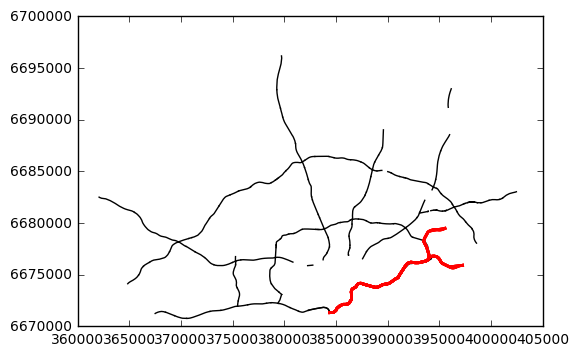

In [5]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import bokeh.mpl as mpl

fig, ax = plt.subplots()


roads.plot(ax=ax, color="black")
metro.plot(ax=ax, color="red", linewidth=2)


#p=mpl.to_bokeh(fig)
#show(p)

In [6]:
from bokeh.palettes import RdYlGn10 as palette #Spectral11 as palette  #YlOrRd7 as palette  #Spectral6 as palette
from bokeh.plotting import output_file

# output to static HTML file
output_file(r"C:\HY-Data\HENTENKA\KOODIT\Opetus\Automating-GIS-processes\AutoGIS-Sphinx\data\accessibility_map.html", title="Accessibility by PT to Helsinki City center")

# Select only necessary columns for our plotting to keep the amount of data minumum
df = data[['x', 'y', 'pt_r_tt_ud', 'pt_r_tt', 'car_r_t', 'from_id', 'label_pt']]
dfsource = ColumnDataSource(data=df)

# Exclude geometry from roads as well
rdf = roads[['x', 'y']]
rdfsource = ColumnDataSource(data=rdf)

# Exclude geometry from water as well
wdf = water[['x', 'y']]
wdfsource = ColumnDataSource(data=wdf)

# Exclude geometry from metro as well
mdf = metro[['x','y']]
mdfsource = ColumnDataSource(data=mdf)

# Exclude geometry from railways
rwdf = rail.drop('geometry', axis=1)
rwdfsource = ColumnDataSource(data=rwdf)

TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

# Flip the colors in color palette
palette.reverse()
color_mapper = LogColorMapper(palette=palette)

# Get min_x and max_x
min_x = data['x_min'].min(); max_x = data['x_max'].max()
min_y = data['y_min'].min(); max_y = data['y_max'].max()

# Zoom out slightly (values are in map units (in this case meters))
zoom_out = 4000
min_x -= zoom_out
max_x += zoom_out
min_y -= zoom_out
max_y += zoom_out

# Move to the left slightly (values are in map units (in this case meters))
move_left = 3000
min_x += move_left
max_x += move_left

p = figure(title="Travel times to Helsinki city center by public transportation", tools=TOOLS, 
           plot_width=650, plot_height=500, active_scroll = "wheel_zoom",
           x_range=(min_x, max_x), y_range=(min_y, max_y) ) 

# Do not add grid line 
p.grid.grid_line_color = None

# Add grid
grid = p.patches('x', 'y', source=dfsource, name="grid",
         fill_color={'field': 'pt_r_tt_ud', 'transform': color_mapper},
         fill_alpha=1.0, line_color="black", line_width=0.03, legend="label_pt")

# Add water
w = p.patches('x', 'y', source=wdfsource, color="blue")

# Add roads
r = p.multi_line('x', 'y', source=rdfsource, color="grey")

# Add metro
m = p.multi_line('x', 'y', source=mdfsource, color="red")

# Add rail ways
rw = p.multi_line('x', 'y', source=rwdfsource, color="black", line_dash="dotted")

# Modify legend location
p.legend.location = "top_right"
p.legend.orientation = "vertical"

# Insert a circle on top of the Central Railway Station (coords in EurefFIN-TM35FIN)
station_x = 385752.214
station_y =  6672143.803
circle = p.circle(x=[station_x], y=[station_y], name="point", size=6, color="yellow")

# Configure hover tooltips
#hover_columns = ["pt_r_tt", "car_r_t"]
#hover_tootips = [(c, '@' + c) for c in hover_columns] 

phover = HoverTool(names=["point"], renderers=[circle])
phover.tooltips=[("Destination", "Railway Station")]

ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("YKR-ID", "@from_id"),
                ("PT time", "@pt_r_tt"),
                ("Car time", "@car_r_t"),
               ]

p.add_tools(ghover)
p.add_tools(phover)


show(p)

In [7]:
import bokeh
bokeh.__version__

'0.12.3'